## Predictive Maintenance of NASA Turbofan Engine Degradation Simulation Dataset
By: Sam Ghalayini  
Date: June 15th 2025  
Class: Deep Learning  

### 1. Brief Description of the Problem
Since starting this specalization I have been wanting to do a predictive project like this. Predicting equipment degradation is vital for every physical system. "Every physical system" covers a huge array of systems: aircraft, medical, robotics, manufacturing, agricultural, etc. Anything with moving parts. A key component of any physcial system is figuring output_layer how long it will last until you need to repair or replace the part. These systems can also include the eletrical grid and predicting if there will be a power outage. With an array of sensors in these systems we can gather minute data that a human would not be able to gather. These modern sensors can gather sequential data that leads up to a system failure so we can then use that data to try and predict when another failure will happen.  
  
A dataset reflective of a machine's ability to collect nuanced data is the NASA Engine Simulation Dataset CMAPSS. In this dataset engineers started hundreds of engines with 21 sensors connected to them and ran the engines until failure. The sensors picked up on different aspects such as temperature, pressure, speed, and fuel-air-ratio. I chose this dataset because of its reliability in run-till-failure data and it models "wear" on a system instead of acute failure that is harder/unreliable to predict.  

There is one paper that we will be working off of called "Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation" by Abhinav Saxena, Kai Goebel, Don Simon, and Neil Eklund.

The task we are specifically given in this notebook is to predict the Remaining Useful Life (RUL) of the engine. Another way to say this is to predict the lifetime of the engine. We can do this because in our training data we have a label of how much RUL each engine has. Our task is specifically a classification of if our engine has RUL or not. The goal of this is project is to assess different deep learning models so that engineers that work with physical systems in the field can be warned ahead of time of a system failure. This way we can avoid failures that incur unnecessary costs, delay production, cause power outages, or even avoid loss of life. The importance of predictive maintenance can even be extrapolated to software and non-physical systems that change over time similarly to "wear". 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import time

### 2. Data Description  
Our data contains hundreds of engine run-till-failure data points with 21 sensors. 17 of those sensors are for calculating the RUL (Remaining Useful Life) and 3 of those sensors are for control settings of the engine and will not be fed to the model. The paper provided in the github repo describes the sensors for our dataset. Each feature in our dataset is a floating point data type. We have 20631 training data entries and 13096 test data entries. 

| Sensor Name | Description                                  |
|-------------|----------------------------------------------|
| T2          | Total temperature at fan inlet (°R)          |
| T24         | Total temperature at LPC outlet (°R)         |
| T30         | Total temperature at HPC outlet (°R)         |
| T50         | Total temperature at LPT outlet (°R)         |
| P2          | Pressure at fan inlet (psia)                 |
| P15         | Total pressure in bypass duct (psia)         |
| P30         | Total pressure at HPC outlet (psia)          |
| Nf          | Physical fan speed (rpm)                     |
| Nc          | Physical core speed (rpm)                    |
| epr         | Engine pressure ratio (P50/P2) (–)           |
| Ps30        | Static pressure at HPC outlet (psia)         |
| phi         | Fuel-flow to Ps30 ratio (pps/psi)            |
| NRf         | Corrected fan speed (rpm)                    |
| NRc         | Corrected core speed (rpm)                   |
| BPR         | Bypass ratio (–)                             |
| farB        | Burner fuel-air ratio (–)                    |
| htBleed     | Bleed-air enthalpy (–)                       |


In [2]:
tf.random.set_seed(42)
np.random.seed(42)
def load_cmapss(fd='FD001', base_path='CMaps/'):
    train_df = pd.read_csv(
        os.path.join(base_path, 'train_{}.txt'.format(fd)),
        sep='\s+', header=None,
        names=['unit','cycle'] +
              ['op_setting_{}'.format(i) for i in range(1,4)] +
              ['sensor_{}'.format(i) for i in range(1,22)]
    )
    test_df = pd.read_csv(
        os.path.join(base_path, 'test_{}.txt'.format(fd)),
        sep='\s+', header=None,
        names=train_df.columns
    )
    rul_df = pd.read_csv(
        os.path.join(base_path, 'RUL_{}.txt'.format(fd)),
        sep='\s+', header=None, names=['RUL_true']
    )

    rul = train_df.groupby('unit')['cycle'].max().reset_index()
    rul.columns = ['unit','max_cycle']
    train_df = train_df.merge(rul, on='unit')
    train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
    train_df.drop(columns=['max_cycle'], inplace=True)
    return train_df, test_df, rul_df

train_df, test_df, test_rul = load_cmapss()
print(train_df.shape, test_df.shape, test_rul.shape)
train_df.head(4)

(20631, 27) (13096, 26) (100, 1)


,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188


### 3. Exploratory Data Analysis (EDA)
Now that we know what our dataset contains and our task of predicting RUL, lets take a deeper look into our dataset and try to learn more that can help us feed the most predicitve features to our models. Since wee are predicting RUL letes take a look at some of the lifetime statistics.  
| RUL   | Value |
|-------|-------|
| count | 100   |
| std   | 46.34 |
| min   | 127   |
| max   | 361   |

Next lets plot those lifetime stats in a histogram chart. The histogram chart tells us that the majority of the engines fail after a lifetime of 200 cycles but the max still goes up to 361. From the correlatoin plot we can tell that sensor 5 and 9 are highly correlated and could be a sign of colinearity. We also have many features/sensors that are empty and should be dropped.  
**Constant sensors:** ['op_setting_3', 'sensor_1', 'sensor_10', 'sensor_18', 'sensor_19', 'sensor_5', 'sensor_6', 'sensor_16']  
The feature engineering we implemented was a sliding context window. So for each entry our modelsaw the last 30 cycles of sensor data. This way we are keeping a moving context for the model to learn from instead of taking each data entry byitself. When our model starts to predict it will predict if the engine will fail within the next window of cycles.  
Lastly before building our models we normalize our data and split our training dataset into a train and validation set so we can test performance metrics.

count    100.000000
mean     205.310000
std       46.342749
min      127.000000
25%      176.000000
50%      198.000000
75%      228.250000
max      361.000000
Name: RUL, dtype: float64


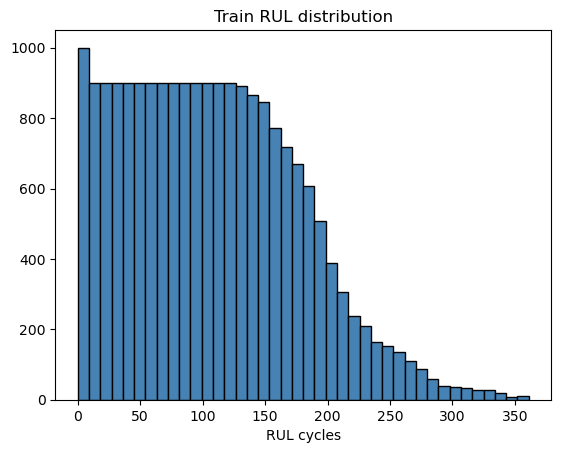

                  mean           std        min        max
sensor_1    518.670000  0.000000e+00   518.6700   518.6700
sensor_2    642.680934  5.000533e-01   641.2100   644.5300
sensor_3   1590.523119  6.131150e+00  1571.0400  1616.9100
sensor_4   1408.933782  9.000605e+00  1382.2500  1441.4900
sensor_5     14.620000  1.776400e-15    14.6200    14.6200
sensor_6     21.609803  1.388985e-03    21.6000    21.6100
sensor_7    553.367711  8.850923e-01   549.8500   556.0600
sensor_8   2388.096652  7.098548e-02  2387.9000  2388.5600
sensor_9   9065.242941  2.208288e+01  9021.7300  9244.5900
sensor_10     1.300000  0.000000e+00     1.3000     1.3000
sensor_11    47.541168  2.670874e-01    46.8500    48.5300
sensor_12   521.413470  7.375534e-01   518.6900   523.3800
sensor_13  2388.096152  7.191892e-02  2387.8800  2388.5600
sensor_14  8143.752722  1.907618e+01  8099.9400  8293.7200
sensor_15     8.442146  3.750504e-02     8.3249     8.5848
sensor_16     0.030000  1.387812e-17     0.0300     0.03

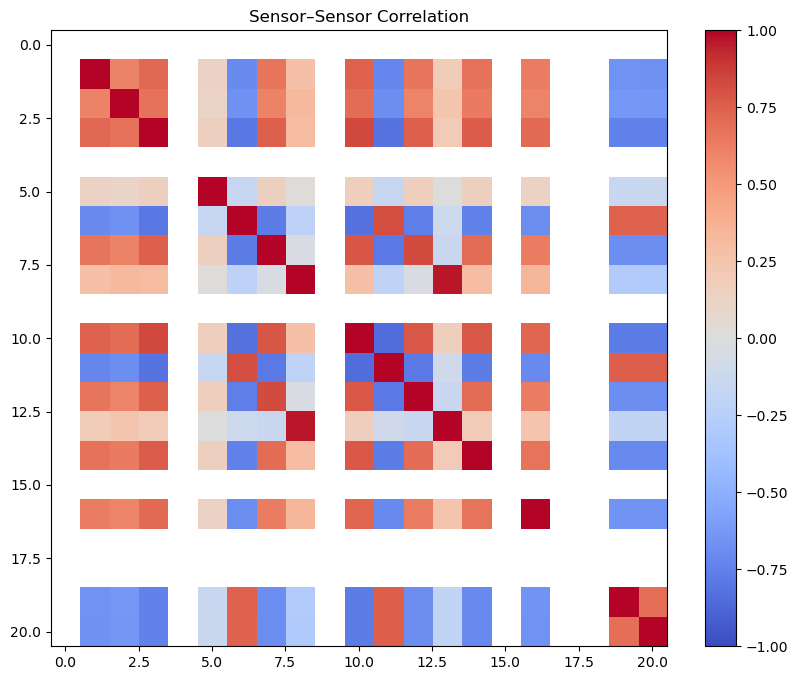

Constant sensors: ['op_setting_3', 'sensor_1', 'sensor_10', 'sensor_18', 'sensor_19', 'sensor_5', 'sensor_6', 'sensor_16']


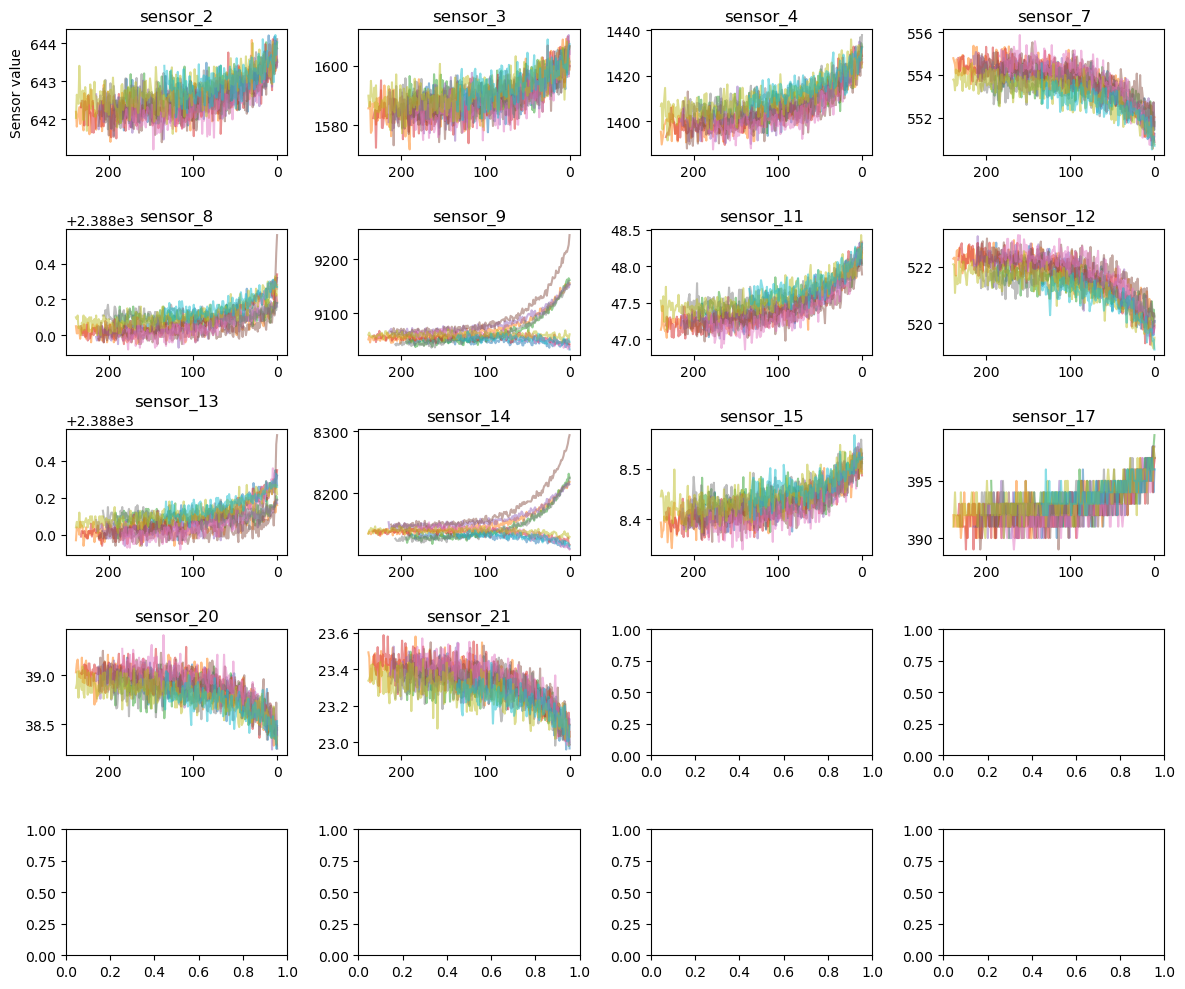

In [3]:
lifetime = train_df.groupby('unit')['RUL'].max()
print(lifetime.describe())

plt.hist(train_df['RUL'], bins=40, color='steelblue', edgecolor='k')
plt.title('Train RUL distribution'); plt.xlabel('RUL cycles')
plt.show()

sensor_stats = train_df.filter(like="sensor").describe().T
print(sensor_stats[['mean','std','min','max']])

plt.figure(figsize=(10,8))
corr = train_df.filter(like='sensor_').corr()
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(); plt.title('Sensor–Sensor Correlation')
plt.show()

def sensor_plot():
    sample_units = train_df['unit'].unique()[::10]
    fig, axes = plt.subplots(5, 4, figsize=(12,10))
    axes = axes.flatten()
    for idx, sensor in enumerate([col for col in train_df.columns if "sensor" in col]):
        for unit in sample_units:
            unit_data = train_df[train_df['unit'] == unit]
            axes[idx].plot(unit_data['RUL'], unit_data[sensor], alpha=0.5)
        axes[idx].invert_xaxis()
        axes[idx].set_title(sensor)
    axes[0].set_ylabel("Sensor value")
    plt.tight_layout()
    plt.show()
# sensor_plot()
desc = train_df.describe().T
remove_sensors = desc[desc["std"] == 0].index.tolist()
remove_sensors.append('sensor_5') 
remove_sensors.append('sensor_6')
remove_sensors.append('sensor_16')
print("Constant sensors:", remove_sensors)

train_df.drop(columns=remove_sensors, inplace=True)
test_df.drop(columns=remove_sensors, inplace=True)
sensor_plot()

In [4]:
def make_sequences(df, label_col='RUL', window=30, step=1):
    model, y = [], []
    feature_cols = [c for c in df.columns if c.startswith('op_set_') or c.startswith('sensor_')]
    units = df['unit'].unique()
    for u in units:
        sub = df[df['unit']==u].reset_index(drop=True)
        seqs = []
        for start in range(0, len(sub)-sliding_window+1, step):
            end = start+sliding_window
            model.append(sub.loc[start:end-1, feature_cols].values)
            y.append(sub.loc[end-1, label_col])
    return np.array(model), np.array(y)
    
sliding_window = 30
X_train_seq, y_train_seq = make_sequences(train_df)
print("X_train_seq:", X_train_seq.shape, "y_train_seq:", y_train_seq.shape)

X_train_seq: (17731, 30, 14) y_train_seq: (17731,)


In [5]:
rul_limit = 30
y_train_bin = (y_train_seq <= rul_limit).astype(int)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_seq, y_train_bin, test_size=0.2, random_state=42,
    stratify=y_train_bin
)
print("Train/Val shapes:", X_tr.shape, X_val.shape, y_tr.shape, y_val.shape)

nsamples, nt, nfeat = X_tr.shape
scaler = StandardScaler().fit(X_tr.reshape(-1,nfeat))
def norm(model):
    flat = model.reshape(-1,nfeat)
    normed = scaler.transform(flat)
    return normed.reshape(model.shape)
X_tr = norm(X_tr)
X_val = norm(X_val)

Train/Val shapes: (14184, 30, 14) (3547, 30, 14) (14184,) (3547,)


### 4. Model Architecture & Hyperparameter Tuning
Since this is the final assignment in this specialization I chose to fit three models we learned in this class and one model that we did not cover in this class but has been gaining popularity recently. The first model we covered in class was a basic Artifical Neural Network (ANN). This ANN flatten the input, has two dense layers, a dropout layer, and one last dense classification layer with a sigmoid activation.  

The second model built below is a convolutional neural network (CNN). Even though CNN's are popular for handling images, they also detect local features that could predict degradation. Just like a 2D convolution layer can detect edges and more complex shapes, a 1D convolutional filter can slide across a flattened time series data to detect spikes short term oscilliations in the engine that could predict engine failure.  

The third model we built is a Recurrent Neural Network. Specifcally with a Long Short-Term Memory layer (LSTM). In the previous week's assignments I chose to implement a GRU for the twitter data. Now that we have slightly longer data I wanted to test the LSTM to see if it can outperform an ANN by capturing "memory" and classifying if an engine has RUL or not.  

The last model of this a Transformer model. Introduced in the 2017 paper "Attention Is All You Need". The model below is built upon tensorflow layers and consits of an attention, normalization, dense, pooling, and dropout layers. The main difference in this model is the "MultiHeadAttention" layer that computes a dot-product between the layers. This dot-product relates the similarity between the different vectors and is a way of telling the model how relevant is the datapoint at a given time.  

I wanted to compare these four different models so I ran them all under a binary cross entropy loss function with an adam optimizer. 

In [6]:
def ann(input_shape):
    input_layer = layers.Input(input_shape)
    model = layers.Flatten()(input_layer)
    model = layers.Dense(64, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(32, activation='relu')(model)
    output_layer = layers.Dense(1, activation='sigmoid')(model)
    return models.Model(input_layer, output_layer, name='ANN')

def cnn(input_shape):
    input_layer = layers.Input(input_shape)
    model = layers.Conv1D(32, kernel_size=5, activation='relu')(input_layer)
    model = layers.MaxPooling1D(2)(model)
    model = layers.Conv1D(16, kernel_size=3, activation='relu')(model)
    model = layers.GlobalAveragePooling1D()(model)
    model = layers.Dense(32, activation='relu')(model)
    output_layer = layers.Dense(1, activation='sigmoid')(model)
    return models.Model(input_layer, output_layer, name='CNN')

def lstm(input_shape):
    input_layer = layers.Input(input_shape)
    model = layers.LSTM(50)(input_layer)
    model = layers.Dropout(0.3)(model)
    output_layer = layers.Dense(1, activation='sigmoid')(model)
    return models.Model(input_layer, output_layer, name='LSTM')

def transformer(input_shape, head_size=64, num_heads=4, ff_dim=128):
    input_layer = layers.Input(input_shape)
    
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    pos_encoding = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    model = input_layer + pos_encoding
    
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(model, model)
    model = layers.Add()([model, attn])
    model = layers.LayerNormalization()(model)
    feed_forward = layers.Dense(ff_dim, activation='relu')(model)
    feed_forward = layers.Dense(input_shape[1])(feed_forward)
    model = layers.Add()([model, feed_forward])
    model = layers.LayerNormalization()(model)
    model = layers.GlobalAveragePooling1D()(model)
    model = layers.Dropout(0.3)(model)
    output_layer = layers.Dense(1, activation='sigmoid')(model)
    return models.Model(input_layer, output_layer, name='Transformer')

In [7]:
all_models = [
    ann((sliding_window, nfeat)),
    cnn((sliding_window, nfeat)),
    lstm((sliding_window, nfeat)),
    transformer((sliding_window, nfeat))]

history = {}
times = {}
for model in all_models:
    start = time.perf_counter()
    print("\nTraining {} now".format(model.name))
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=early_stopping,
        verbose=2
    )
    history[model.name] = hist
    end = time.perf_counter()
    times[model.name] = end - start
for model in all_models:
    print("{} model took: {:.2f} seconds".format(model.name, times[model.name]))

2025-06-24 06:58:10.264498: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-06-24 06:58:10.264522: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-06-24 06:58:10.264525: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1750762690.264535 13954890 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1750762690.264550 13954890 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



Training ANN now
Epoch 1/50


2025-06-24 06:58:10.649078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


444/444 - 4s - 8ms/step - accuracy: 0.8104 - loss: 0.7211 - val_accuracy: 0.8486 - val_loss: 0.4741
Epoch 2/50
444/444 - 3s - 7ms/step - accuracy: 0.7992 - loss: 2.1681 - val_accuracy: 0.8179 - val_loss: 1.5694
Epoch 3/50
444/444 - 3s - 7ms/step - accuracy: 0.8115 - loss: 2.8247 - val_accuracy: 0.8802 - val_loss: 1.0692
Epoch 4/50
444/444 - 3s - 6ms/step - accuracy: 0.8143 - loss: 3.6345 - val_accuracy: 0.8351 - val_loss: 2.1917
Epoch 5/50
444/444 - 3s - 7ms/step - accuracy: 0.7900 - loss: 7.4589 - val_accuracy: 0.7908 - val_loss: 8.2296
Epoch 6/50
444/444 - 3s - 6ms/step - accuracy: 0.8020 - loss: 10.1250 - val_accuracy: 0.8483 - val_loss: 3.5159
Epoch 7/50
444/444 - 3s - 6ms/step - accuracy: 0.8120 - loss: 8.8669 - val_accuracy: 0.7953 - val_loss: 10.8084
Epoch 8/50
444/444 - 3s - 7ms/step - accuracy: 0.8222 - loss: 9.5987 - val_accuracy: 0.8633 - val_loss: 6.3819
Epoch 9/50
444/444 - 3s - 7ms/step - accuracy: 0.7968 - loss: 14.4717 - val_accuracy: 0.8799 - val_loss: 4.4129
Epoch 10/

### 5. Results & Analysis
Out of the four models we ran the data on we acheived decently high accuracy and low loss for each of them. The worst to perform was the ANN. The accuracy jumped around then stopped because of the early stopping condition. Next was the transformer model which peaked around 10 epochs then gradually started to decline. The two rivaling for the number one spot was the LSTM and the CNN. The CNN took the top spot by 0.001 and misclassified the least. The first three models misclassified false negatives the most and the transformer misclassified false positives the most.

| Model        | Accuracy | Precision | Recall | F1-score | False Positives | False Negatives | Time |
|--------------|:--------:|:---------:|:------:|:--------:|:-----------:|:-----------:|:-----:|
| ANN          |  0.875   |   0.653   | 0.610  |  0.631   |     201     |     242     | 33.06|
| CNN          |  0.992   |   0.971   | 0.985  |  0.978   |      18     |       9     | 135.91|
| LSTM         |  0.991   |   0.962   | 0.987  |  0.975   |      24     |       8     | 120.78|
| Transformer  |  0.979   |   0.946   | 0.935  |  0.941   |      33     |      40     | 195.02|


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
         model       acc      prec       rec        f1
0          ANN  0.848604  0.541294  0.877419  0.669538
1          CNN  0.989569  0.969404  0.970968  0.970185
2         LSTM  0.987313  0.951334  0.977419  0.964200
3  Transformer  0.975472  0.930533  0.929032  0.929782
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


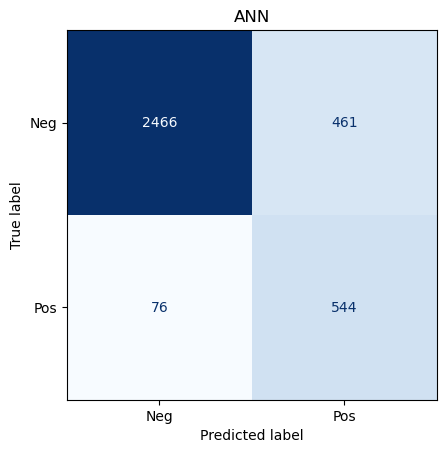

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


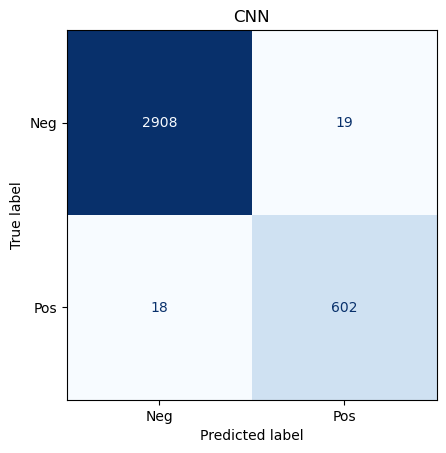

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


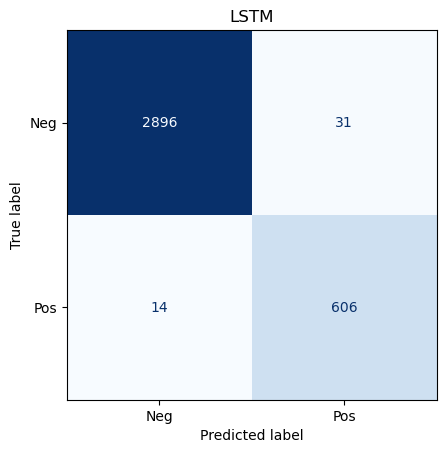

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


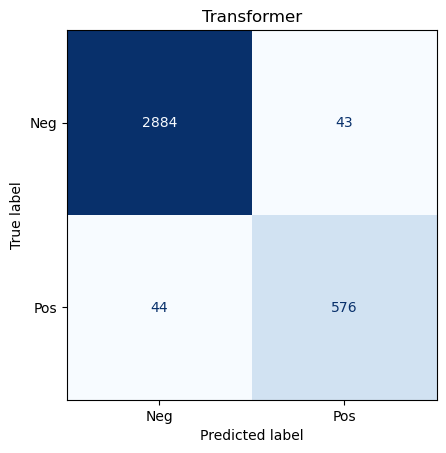

In [15]:
results = []
for model in all_models:
    y_pred = (model.predict(X_val) > 0.5).astype(int).ravel()
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    results.append((model.name, acc, prec, rec, f1))
    
res_df = pd.DataFrame(results, columns=['model','acc','prec','rec','f1'])
print(res_df)
from sklearn.metrics import ConfusionMatrixDisplay
# confusion matrices
for model in all_models:
    y_pred = (model.predict(X_val) > 0.5).astype(int).ravel()
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neg','Pos'])
    disp.plot(cmap='Blues', values_format='d', colorbar=False)
    disp.ax_.set_title(str(model.name))
    plt.show()
    # print("\nConfusion matrix for {}: {}\n".format(model.name, cm))

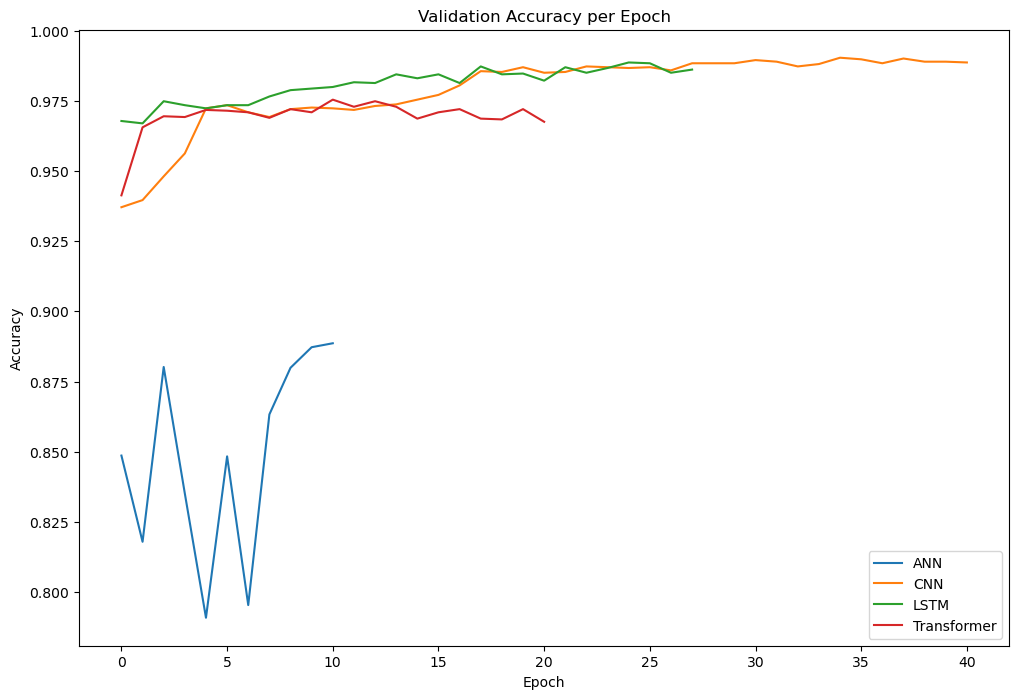

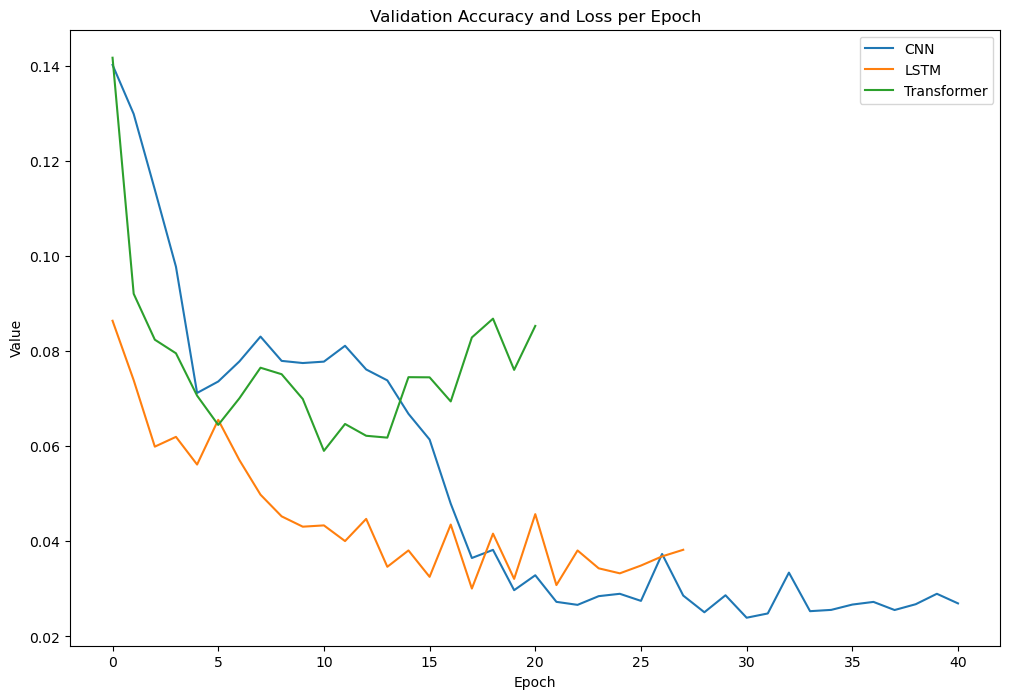

In [16]:
plt.figure(figsize=(12,8))
for name, hist in history.items():
    plt.plot(hist.history['val_accuracy'], label=str(name))
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
for name, hist in history.items():
    if name == 'ANN':
        continue
    plt.plot(hist.history['val_loss'], label=str(name))
plt.title('Validation Accuracy and Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='best')
plt.show()

### 6. Conclusion
Throughout this project I learned about the critical role of feature engineering in predictive modeling. The context_window seemed to make most influential factor in performance. What surprised me the most was how gradual and for how long the CNN accuracy grew. I was not expecting a CNN to gather the latent features that predict an engine failing. What also surprised me was how long the transformer model took to train.  

In the future I would like to improve upon this notebook by generalizing the models to fit to any time series predictive degradation dataset. Rather than optimizing performance for this specific dataset, my objective would be to develop a generalized model capable of predicting remaining useful life (RUL) over different domains.

### 7. Deliverables Checklist
1. Jupyter Notebook
2. Video Presentation
3. Github Repo

### 8. References
- https://c3.ndc.nasa.gov/dashlink/static/media/publication/2008_IEEEPHM_CMAPPSDamagePropagation.pdf
- https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data#:~:text=The%20engine%20is%20operating%20normally,values%20for%20the%20test%20data
- https://www.tensorflow.org/api_docs/python/tfm/nlp/layers/Transformer
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
- https://arxiv.org/abs/1706.03762
- To get datasets:
- https://ieee-dataport.org/documents/nasa-turbofan-jet-engine-data-set#files
- https://www.kaggle.com/datasets/behrad3d/nasa-cmaps/data 